In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
# pprevent annoying tensorflow warning
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings
#pd.set_option('max_columns', None)
#pd.set_option('max_rows', 90)
warnings.simplefilter("ignore")

In [2]:
img_dir=r'./honey_bees'
csvpath=r'./bee_data.csv'
df=pd.read_csv(csvpath)
# drop columns that we will not be using
df=df.drop(['date', 'time', 'location', 'zip code', 'health', 'pollen_carrying', 'caste'], axis=1)
# rename the columns
df.columns= ['filepaths', 'labels']
# make the filepaths column contain the full path to the image
df['filepaths']=df['filepaths'].apply(lambda x: os.path.join(img_dir, x))
# lets check to see if there are any missing values in df
print (' The total number of missing values in df is ', df.isna().sum().sum())
print (' The dataframe initially has ', len(df), ' rows')

 The total number of missing values in df is  0
 The dataframe initially has  5172  rows


In [3]:
# lets check to make sure every entry in filepaths column has an image in the img_dir
has_img=df['filepaths'].apply(lambda  x: os.path.isfile(x))
df=df[has_img]
print (df.head())
print ('After checking that each filepath has an image the number of rows in df is ', len(df))
# split df into a train_df, a test_df and a valid_df
train_df, dummy_df= train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])
valid_df, test_df= train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

                  filepaths labels
0  ./honey_bees/041_066.png     -1
1  ./honey_bees/041_072.png     -1
2  ./honey_bees/041_073.png     -1
3  ./honey_bees/041_067.png     -1
4  ./honey_bees/041_059.png     -1
After checking that each filepath has an image the number of rows in df is  5172
train_df length:  4137   test_df length:  518   valid_df length:  517


In [4]:
# lets look at the subspecies labels and determine how many images there are for each class
groups=train_df.groupby('labels')
class_count = len(groups)
print (' There are ', class_count, ' classes in the dataframe')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
for label in train_df['labels'].unique():
      group=groups.get_group(label)      
      print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

 There are  7  classes in the dataframe
            CLASS               IMAGE COUNT 
              -1                    342     
      Italian honey bee            2406     
     Carniolan honey bee            401     
    1 Mixed local stock 2           378     
      Russian honey bee             421     
    VSH Italian honey bee           159     
      Western honey bee             30      


In [5]:
# Lets take a random sample of 300 images and determine the average image height and width
img_df=df.sample(n=300,replace=False,random_state=123, axis=0)
ht=0
wt=0
for i in range(len(img_df)):
    fpath=img_df['filepaths'].iloc[i]
    img =plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
have=int(ht/300)
wave=int(wt/300)
print ('Average height: ', have, ' Average width: ', wave, ' aspect ratio: ', have/wave)

Average height:  73  Average width:  74  aspect ratio:  0.9864864864864865


In [6]:
def trim (df, max_size, min_size, column):
    df=df.copy()
    original_class_count= len(list(df[column].unique()))    
    sample_list=[] 
    groups=df.groupby(column)
    for label in df[column].unique():        
        group=groups.get_group(label)
        sample_count=len(group)         
        if sample_count> max_size :
            strat=group[column]
            samples,_=train_test_split(group, train_size=max_size, shuffle=True, random_state=123, stratify=strat)            
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    final_class_count= len(list(df[column].unique())) 
    if final_class_count != original_class_count:
        print ('*** WARNING***  dataframe has a reduced number of classes from ', original_class_count,' to ', final_class_count )
    groups=df.groupby('labels')
    print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
    for label in train_df['labels'].unique():
        group=groups.get_group(label)      
        print('{0:^30s} {1:^13s}'.format(label, str(len(group))))
    return df

In [7]:
max_samples=400
min_samples=0
column='labels'
train_df=trim(train_df, max_samples, min_samples, column)

            CLASS               IMAGE COUNT 
              -1                    342     
      Italian honey bee             400     
     Carniolan honey bee            400     
    1 Mixed local stock 2           378     
      Russian honey bee             400     
    VSH Italian honey bee           159     
      Western honey bee             30      


In [8]:
def balance(train_df,max_samples, min_samples, column, working_dir, image_size):
    train_df=train_df.copy()        
    # make directories to store augmented images
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path)
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                           height_shift_range=.2, zoom_range=.2)
    groups=train_df.groupby('labels') # group by class
    for label in train_df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< max_samples: # if the class has less than target number of images
            aug_img_count=0
            delta=max_samples-sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images    
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=image_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    if total>0:
        aug_fpaths=[]
        aug_labels=[]
        classlist=os.listdir(aug_dir)
        for klass in classlist:
            classpath=os.path.join(aug_dir, klass)     
            flist=os.listdir(classpath)    
            for f in flist:        
                fpath=os.path.join(classpath,f)         
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries=pd.Series(aug_fpaths, name='filepaths')
        Lseries=pd.Series(aug_labels, name='labels')
        aug_df=pd.concat([Fseries, Lseries], axis=1)
        train_df=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
   
    print (list(train_df['labels'].value_counts()) )
    return train_df 

In [9]:
working_dir=r'./'
img_size=(70,70)
train_df=balance(train_df, max_samples, min_samples, column, working_dir, img_size)


Found 342 validated image filenames.
Found 378 validated image filenames.
Found 159 validated image filenames.
Found 30 validated image filenames.
Total Augmented images created=  691
[400, 400, 400, 400, 400, 400, 400]


In [10]:
batch_size=40 # We will use and EfficientetB3 model, with image size of (200, 250) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )
t_and_v_gen=ImageDataGenerator()
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
print ('{0:^25s}{1:^12s}'.format('class name', 'class index'))
for klass, index in zip(classes, class_indices):
    print(f'{klass:^25s}{str(index):^12s}')

Found 2800 validated image filenames belonging to 7 classes.
Found 517 validated image filenames belonging to 7 classes.
Found 518 validated image filenames belonging to 7 classes.
test batch size:  74   test steps:  7  number of classes :  7
       class name        class index 
           -1                 0      
  1 Mixed local stock 2       1      
   Carniolan honey bee        2      
    Italian honey bee         3      
    Russian honey bee         4      
  VSH Italian honey bee       5      
    Western honey bee         6      


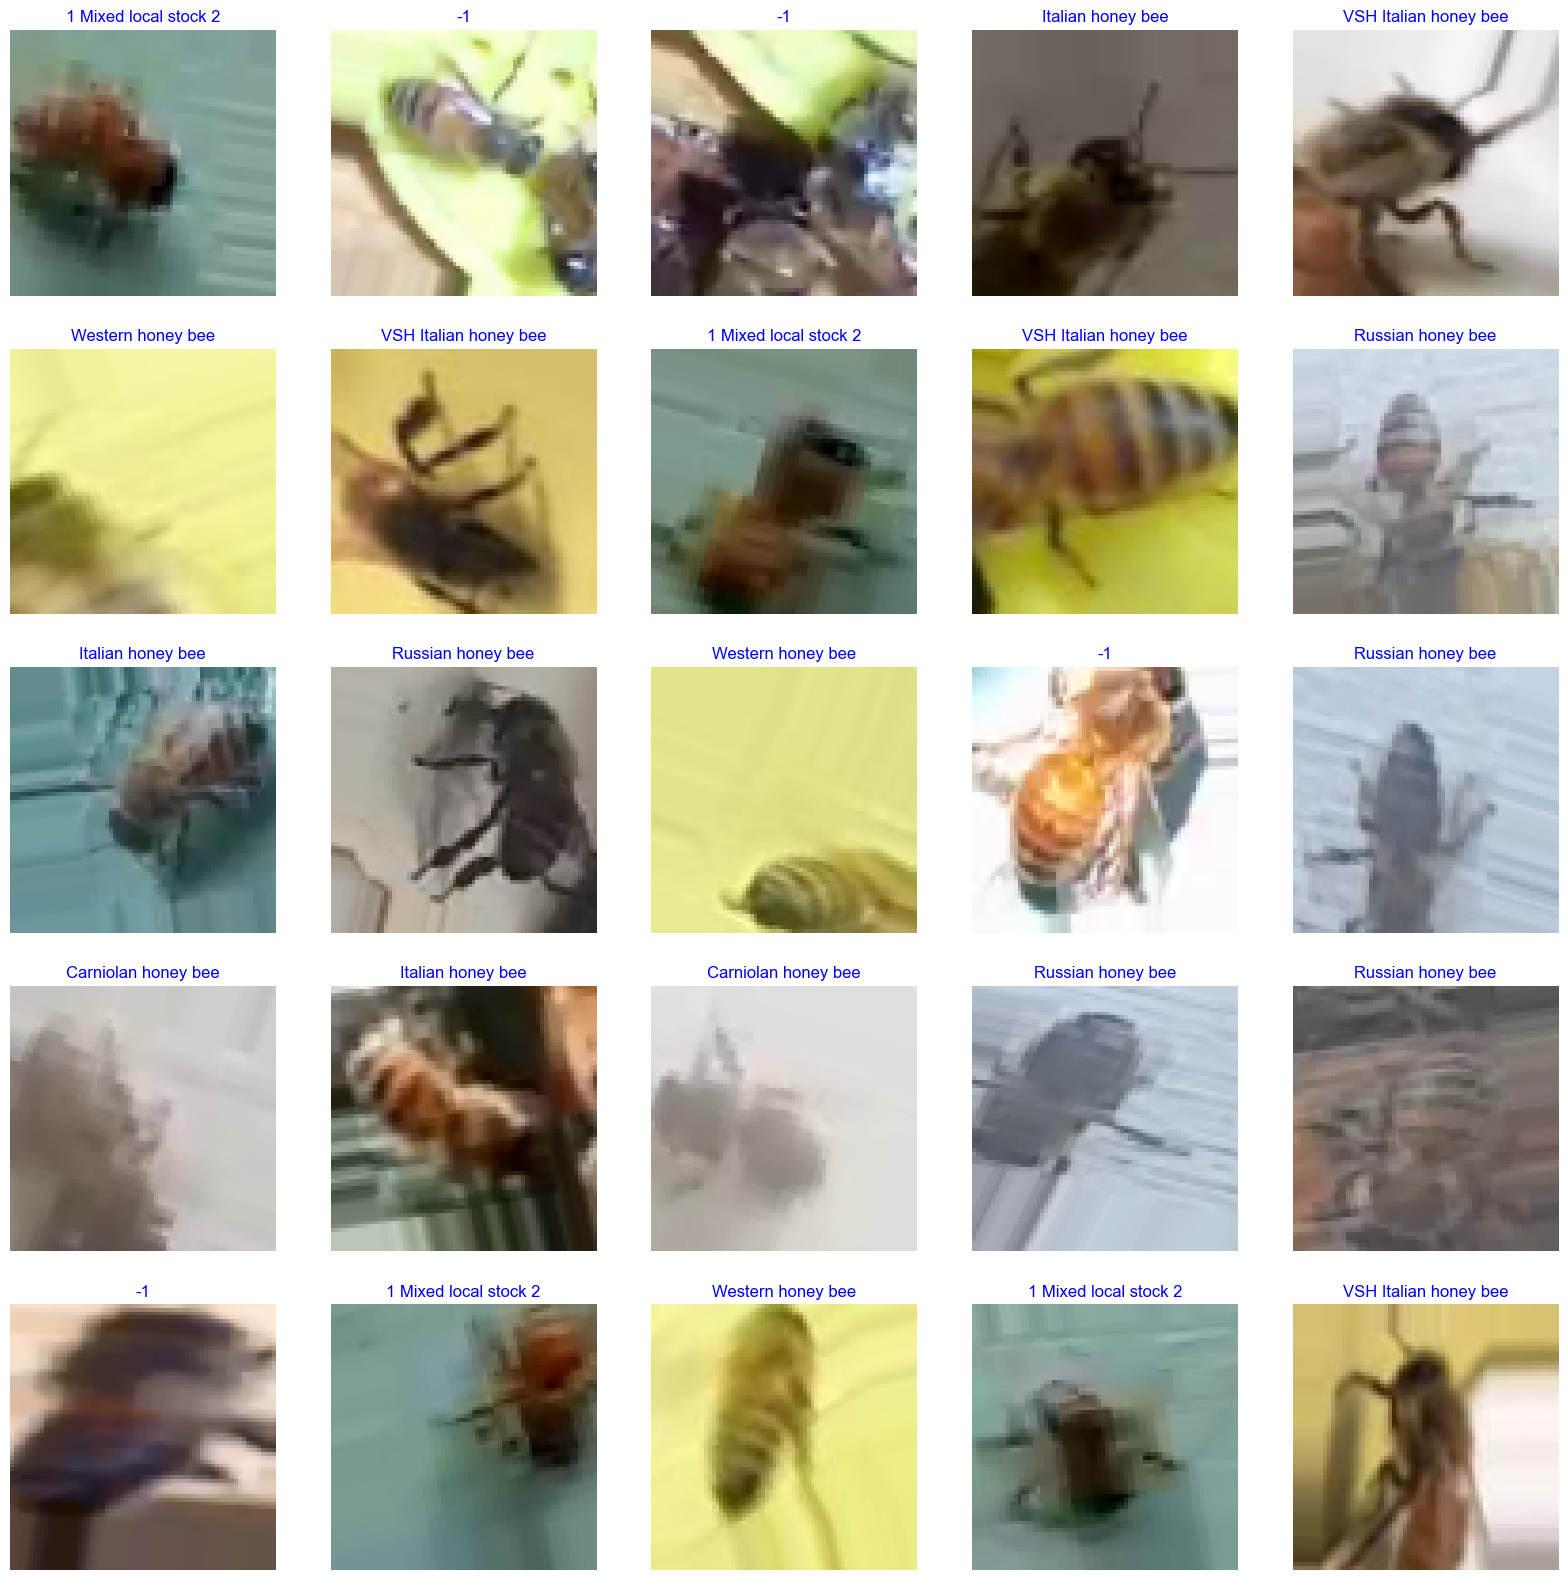

In [11]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

In [18]:
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(128, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

43941136/43941136 [==============================] - 8s 0us/step


In [19]:
class ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training     
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)

In [20]:
epochs=40
ask_epoch=10
ask=ASK(model, epochs,  ask_epoch)
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1,restore_best_weights=True)
callbacks=[rlronp, estop, ask]

In [21]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 10  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40


2022-09-13 13:55:38.457528: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


70/70 [==============================] - 38s 481ms/step - loss: 23.4906 - accuracy: 0.6246 - val_loss: 19.8084 - val_accuracy: 0.6286 - lr: 0.0010
Epoch 2/40
70/70 [==============================] - 33s 471ms/step - loss: 16.1144 - accuracy: 0.8289 - val_loss: 14.2248 - val_accuracy: 0.7350 - lr: 0.0010
Epoch 3/40
70/70 [==============================] - 34s 486ms/step - loss: 11.2881 - accuracy: 0.8768 - val_loss: 9.8525 - val_accuracy: 0.8124 - lr: 0.0010
Epoch 4/40
70/70 [==============================] - 34s 489ms/step - loss: 8.1616 - accuracy: 0.9129 - val_loss: 7.1023 - val_accuracy: 0.8704 - lr: 0.0010
Epoch 5/40
70/70 [==============================] - 34s 487ms/step - loss: 5.9588 - accuracy: 0.9354 - val_loss: 5.2809 - val_accuracy: 0.8762 - lr: 0.0010
Epoch 6/40
70/70 [==============================] - 31s 443ms/step - loss: 4.4462 - accuracy: 0.9471 - val_loss: 3.8907 - val_accuracy: 0.8956 - lr: 0.0010
Epoch 7/40
70/70 [==============================] - 33s 471ms/step - l

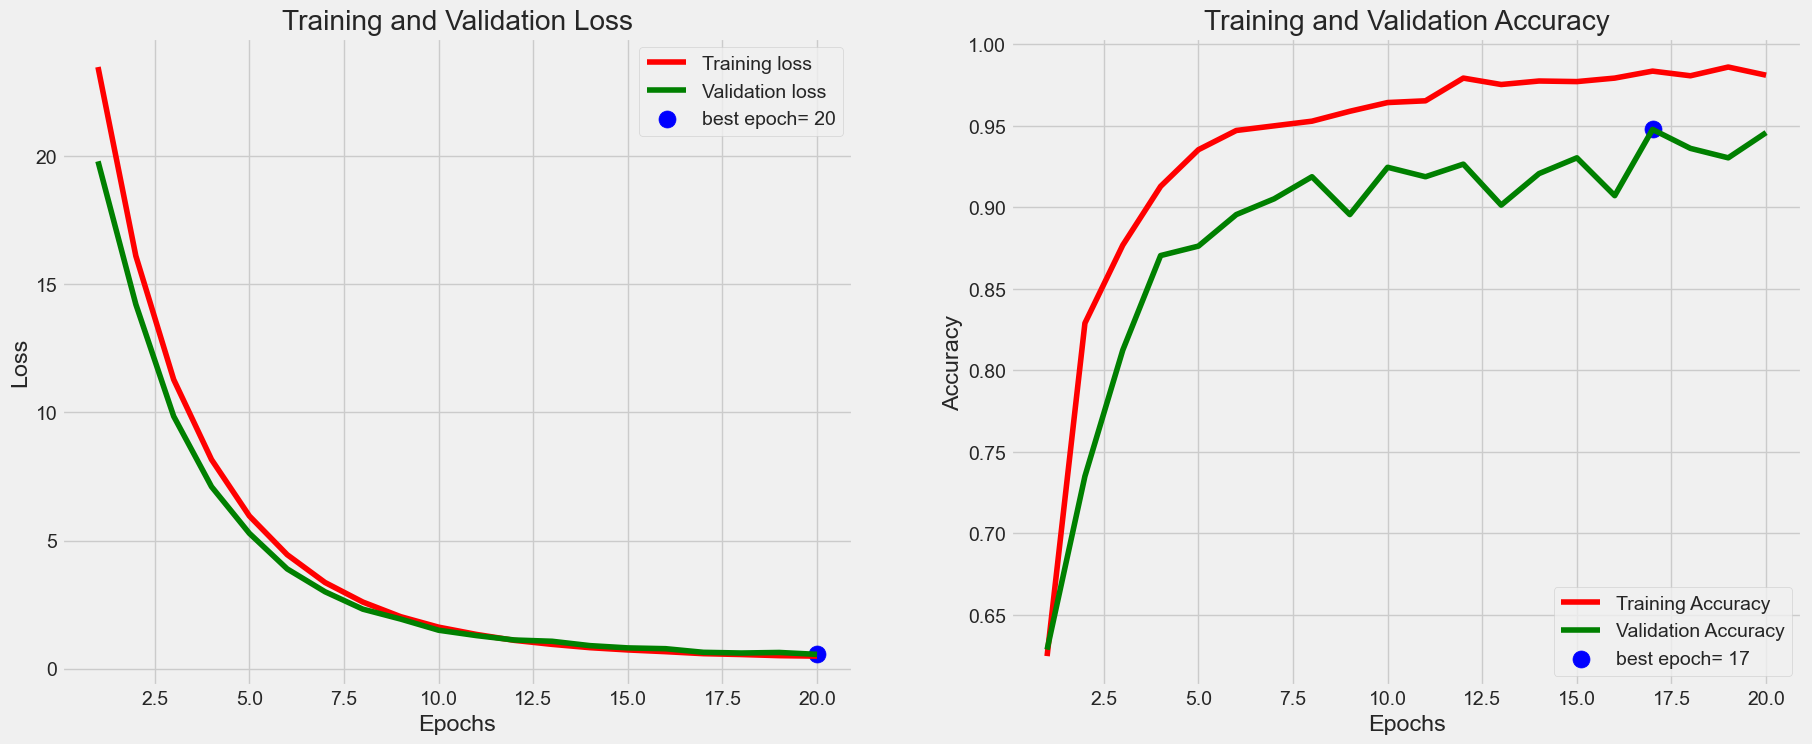

In [22]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)

7/7 [==============================] - 2s 195ms/step
there were 23 in 518 tests for an accuracy of  95.56


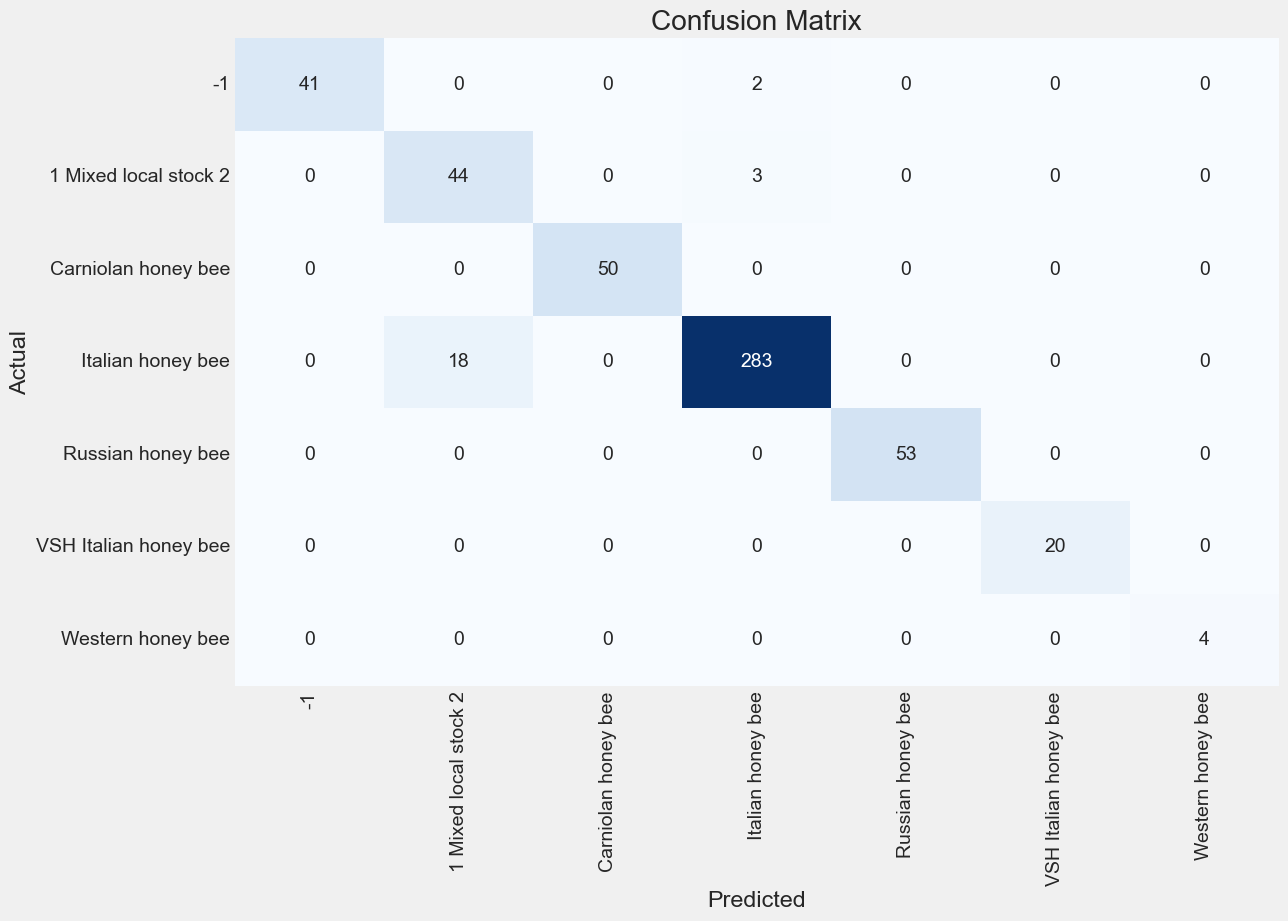

Classification Report:
----------------------
                        precision    recall  f1-score   support

                   -1     1.0000    0.9535    0.9762        43
1 Mixed local stock 2     0.7097    0.9362    0.8073        47
  Carniolan honey bee     1.0000    1.0000    1.0000        50
    Italian honey bee     0.9826    0.9402    0.9610       301
    Russian honey bee     1.0000    1.0000    1.0000        53
VSH Italian honey bee     1.0000    1.0000    1.0000        20
    Western honey bee     1.0000    1.0000    1.0000         4

             accuracy                         0.9556       518
            macro avg     0.9560    0.9757    0.9635       518
         weighted avg     0.9636    0.9556    0.9579       518



In [23]:
y_pred= []
y_true=test_gen.labels
errors=0
preds=model.predict(test_gen, steps=test_steps, verbose=1) # predict on the test set
tests=len(preds)
for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
        y_pred.append(pred_index)
acc=( 1-errors/tests) * 100
print(f'there were {errors} in {tests} tests for an accuracy of {acc:6.2f}')
ypred=np.array(y_pred)
ytrue=np.array(y_true)
cm = confusion_matrix(ytrue, ypred )
# plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
print("Classification Report:\n----------------------\n", clr)

In [24]:
subject='bees' 
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5' 
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc ) 

model was saved as  ./bees_95.55.h5


In [12]:
test_gen

In [15]:
test_df

,filepaths,labels
3458,./honey_bees/015_1147.png,Italian honey bee
1752,./honey_bees/040_557.png,Italian honey bee
1938,./honey_bees/040_536.png,Italian honey bee
1765,./honey_bees/040_191.png,Italian honey bee
2260,./honey_bees/046_039.png,Carniolan honey bee
...,...,...
4196,./honey_bees/038_411.png,1 Mixed local stock 2
5161,./honey_bees/033_097.png,Western honey bee
2478,./honey_bees/004_112.png,Italian honey bee
2247,./honey_bees/046_166.png,Carniolan honey bee
